In [1]:
%matplotlib inline


# Inverting scattering via mse
This script aims to quantify the information loss for natural images by
performing a reconstruction of an image from its scattering coefficients via a
L2-norm minimization.


## Imports



In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torch import optim
from scipy.misc import face

from kymatio.torch import Scattering2D

device = "cuda" if torch.cuda.is_available() else "cpu"

## Load test image



/var/folders/7y/n8m7fb8j0zq8tgbywqdqb_fm0000gn/T/ipykernel_61801/4267053241.py:2: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  src_img = src_img.resize((512, 384), Image.ANTIALIAS)


Image shape:  (3, 384, 512)


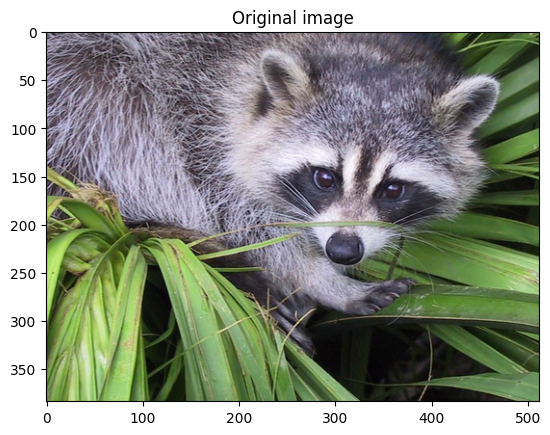

In [12]:
src_img = Image.fromarray(face())
src_img = src_img.resize((512, 384), Image.ANTIALIAS)
src_img = np.array(src_img).astype(np.float32)
src_img = src_img / 255.0
plt.imshow(src_img)
plt.title("Original image")

src_img = np.moveaxis(src_img, -1, 0)  # HWC to CHW
max_iter = 15 # number of steps for the GD
print("Image shape: ", src_img.shape)
channels, height, width = src_img.shape

## Main loop



coefficients are a <class 'torch.Tensor'>, shape: torch.Size([3, 17, 96, 128])
Epoch 14, loss: 0.0011064881691709164
PSNR: 14.83dB for order 1 and J=2
coefficients are a <class 'torch.Tensor'>, shape: torch.Size([3, 33, 24, 32])
Epoch 14, loss: 0.00026223922031931586
PSNR: 14.95dB for order 1 and J=4


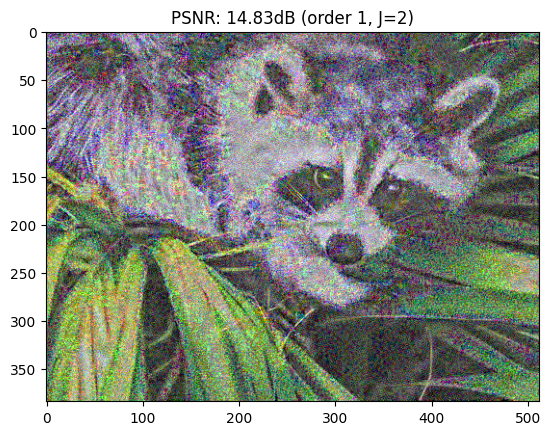

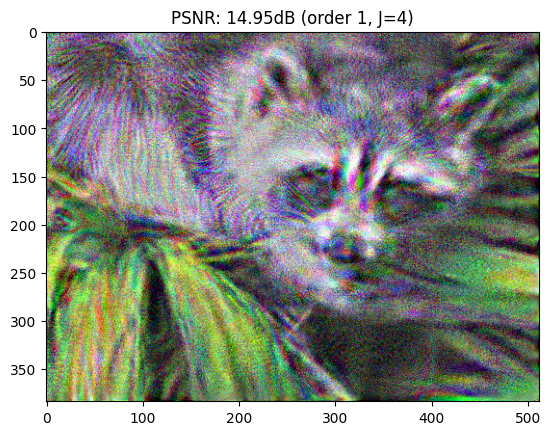

[0.0018725222907960415, 0.0028134190943092108, 0.0010688797337934375, 0.0007743812748230994, 0.0010688102338463068, 0.0008047712035477161, 0.00048564784810878336, 0.00044829133548773825, 0.0004919812781736255, 0.00042171450331807137, 0.00030590646201744676, 0.0002633508702274412, 0.0002763295779004693, 0.0002622392203193158]


In [15]:
for order in [1]:
    for J in [2, 4]:

        # Compute scattering coefficients
        scattering = Scattering2D(J=J, shape=(height, width), max_order=order)
        if device == "cuda":
            scattering = scattering.cuda()
            max_iter = 500
        src_img_tensor = torch.from_numpy(src_img).to(device).contiguous()
        scattering_coefficients = scattering(src_img_tensor)
        print('coefficients are a {}, shape: {}'.format(type(scattering_coefficients),scattering_coefficients.shape))
        #print('Scatter mean: {}, portion above: xx'.format(np.mean(scattering_coefficients)))

        # Create trainable input image
        input_tensor = torch.rand(src_img.shape, requires_grad=True, device=device)

        # Optimizer hyperparams
        optimizer = optim.Adam([input_tensor], lr=1)

        losses = []
        # Training
        best_img = None
        best_loss = float("inf")
        for epoch in range(1, max_iter):
            new_coefficients = scattering(input_tensor)
            loss = F.mse_loss(input=new_coefficients, target=scattering_coefficients)
            losses.append(loss.detach().cpu().item())
            print("Epoch {}, loss: {}".format(epoch, loss.item()), end="\r")
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if loss < best_loss:
                best_loss = loss.detach().cpu().item()
                best_img = input_tensor.detach().cpu().numpy()

        best_img = np.clip(best_img, 0.0, 1.0)

        # PSNR
        mse = np.mean((src_img - best_img) ** 2)
        psnr = 20 * np.log10(1.0 / np.sqrt(mse))
        print("\nPSNR: {:.2f}dB for order {} and J={}".format(psnr, order, J))

        # Plot
        plt.figure()
        plt.imshow(np.moveaxis(best_img, 0, -1))
        plt.title("PSNR: {:.2f}dB (order {}, J={})".format(psnr, order, J))

plt.show()

print(losses)

(array([5., 3., 1., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]),
 array([0.00026441, 0.00043504, 0.00060568, 0.00077632, 0.00094696,
        0.00111759, 0.00128823, 0.00145887, 0.0016295 , 0.00180014,
        0.00197078, 0.00214141, 0.00231205, 0.00248269, 0.00265332,
        0.00282396]),
 <BarContainer object of 15 artists>)

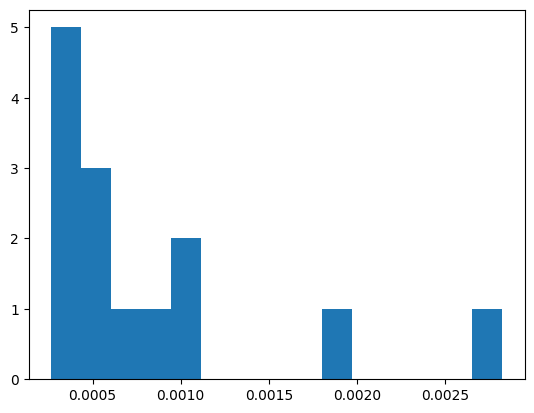

In [7]:
plt.hist(losses,bins=15)

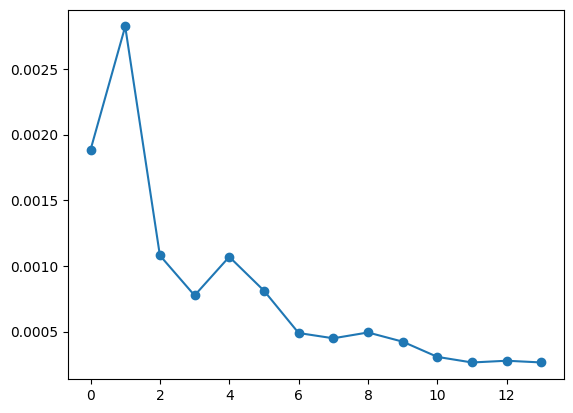

In [10]:
#plt.scatter(range(0,14),losses)
plt.plot(range(0,14),losses,'-o')